# Wilson Model

The Wilson model is a simplified two-variable model of neuronal dynamics that captures the essential features of neuronal excitability and oscillations. Unlike the Morris-Lecar model which explicitly models calcium and potassium conductances based on Hodgkin-Huxley formalism, the Wilson model provides a more phenomenological description using a cubic nullcline for the voltage variable and a linear recovery variable. This makes it computationally efficient while still capturing key neuronal behaviors like excitability and oscillations.

## Key Properties

1. **Cubic Nullcline**: Voltage dynamics follow a cubic function that enables multiple equilibrium points
2. **Linear Recovery Variable**: A single recovery variable provides negative feedback
3. **Type I or Type II Excitability**: Can be configured for either gradual (Type I) or abrupt (Type II) transitions to firing
4. **Reduced Complexity**: Only two state variables compared to four in Hodgkin-Huxley
5. **Phase Plane Analysis**: Amenable to graphical analysis through phase plane methods

## Mathematical Description

The model is described by two coupled differential equations:

dV/dt = F(V) - w + I

dw/dt = (G(V) - w)/τ

Where F(V) is a cubic function: F(V) = V(V-a)(1-V)
And G(V) is typically linear: G(V) = bV

When implemented computationally, spike detection is often added:
When V ≥ Vth:
  • A spike is recorded
  • (No explicit reset, dynamics continue)

Parameters:
- V: Membrane potential
- w: Recovery variable
- a: Parameter controlling the leftmost zero of F(V) (typically 0.1-0.2)
- b: Recovery variable gain (typically 0.5-0.8)
- τ: Time constant of recovery variable (typically 5-15 ms)
- I: External current input
- Vth: Spike detection threshold (typically 0.8, if implemented)

State Variables:
- V: Membrane potential (initialize near resting state)
- w: Recovery variable (initialize at G(V))

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize state variables
   - Set V to resting state (typically the leftmost equilibrium point)
   - Set w = G(V)
   - Create empty list for spike times

2. For each time step from t=0 to t=tmax:
   
   a. Check if spike detection threshold is reached (optional)
      - If V ≥ Vth:
        • Record spike time
   
   b. Compute derivative terms
      - dV/dt = F(V) - w + I
      - dw/dt = (G(V) - w)/τ
   
   c. Update state variables using numerical integration
      - V = V + dV/dt * dt
      - w = w + dw/dt * dt
   
   d. Store variables for plotting
      - Record V, w at current time step
   
   e. Increment time: t = t + dt

3. Analyze and visualize results
   - Plot membrane potential (V) vs time
   - Plot recovery variable (w) vs time
   - Generate phase plane plot (V vs w)
   - Calculate firing rate and adaptation properties

## Characteristic Behaviors

1. **Resting State**: Stable equilibrium at intersection of nullclines when I is low
2. **Threshold Behavior**: Separatrix between returning to rest and firing a spike
3. **Limit Cycle Oscillations**: Self-sustained firing pattern at higher input currents
4. **Bistability**: Coexistence of resting state and oscillatory behavior in certain parameter regimes
5. **Adaptation**: Can show firing rate adaptation with parameter adjustments
6. **Post-inhibitory Rebound**: Firing after release from inhibition

## Biological Mechanisms Represented

The variables represent:
- V: Membrane potential, reflecting the net ionic currents across the membrane
- w: Combined effects of activation/inactivation of voltage-gated channels (primarily K+)
- F(V): Represents fast positive feedback currents (similar to Na+ currents)
- G(V): Represents slower negative feedback mechanisms (similar to K+ currents)

## Applications

The Wilson model is particularly useful for:
- Studying basic neuronal excitability and firing patterns
- Educational demonstrations of neuronal dynamics
- Network models requiring computationally efficient neuron models
- Phase plane analysis of neuronal behaviors
- Studying transitions between resting, oscillating, and excitable states
- Modeling different neuron classes (e.g., regular spiking, fast spiking) with parameter changes
- Understanding fundamental concepts like bifurcations in neuronal dynamics

In [4]:
class Wilson():
    def __init__(self, Cm, I, time_steps, 
                 g_Na=120, g_K=36, g_L=0.3, 
                 E_Na=50, E_K=-77, E_L=-54.4):
        # Membrane parameters
        self.Cm = Cm          # Membrane capacitance (nF)
        self.I = I            # Input current (nA)
        self.time_steps = time_steps
        
        # Conductance parameters
        self.g_Na = g_Na      # Maximum sodium conductance
        self.g_K = g_K        # Maximum potassium conductance
        self.g_L = g_L        # Leak conductance
        
        # Reversal potentials
        self.E_Na = E_Na      # Sodium reversal potential (mV)
        self.E_K = E_K        # Potassium reversal potential (mV)
        self.E_L = E_L        # Leak reversal potential (mV)
    
    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65) / 18)
    
    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    def m_inf(self, V):
        return self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
    
    def h_inf(self, V):
        return self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
    
    def n_inf(self, V):
        return self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
    
    def simulate(self):
        # Initialize arrays for storing voltage and state variables
        dt = self.time_steps[1] - self.time_steps[0]  # Time step size
        n_steps = len(self.time_steps)
        
        # State variables
        V = np.zeros(n_steps)
        m = np.zeros(n_steps)
        h = np.zeros(n_steps)
        n = np.zeros(n_steps)
        spikes = []
        
        # Initial conditions
        V[0] = -65.0  # Initial voltage (mV)
        m[0] = self.m_inf(V[0])
        h[0] = self.h_inf(V[0])
        n[0] = self.n_inf(V[0])
        
        # Simulate for each time step
        for i in range(n_steps-1):
            # Current voltage and gating variables
            v = V[i]
            m_current = m[i]
            h_current = h[i]
            n_current = n[i]
            
            # Calculate ionic currents
            I_Na = self.g_Na * m_current**3 * h_current * (v - self.E_Na)
            I_K = self.g_K * n_current**4 * (v - self.E_K)
            I_L = self.g_L * (v - self.E_L)
            
            # Update voltage using Euler method
            dVdt = (self.I - I_Na - I_K - I_L) / self.Cm
            V[i+1] = v + dVdt * dt
            
            # Update gating variables
            alpha_m = self.alpha_m(v)
            beta_m = self.beta_m(v)
            alpha_h = self.alpha_h(v)
            beta_h = self.beta_h(v)
            alpha_n = self.alpha_n(v)
            beta_n = self.beta_n(v)
            
            tau_m = 1.0 / (alpha_m + beta_m)
            tau_h = 1.0 / (alpha_h + beta_h)
            tau_n = 1.0 / (alpha_n + beta_n)
            
            m_inf = alpha_m / (alpha_m + beta_m)
            h_inf = alpha_h / (alpha_h + beta_h)
            n_inf = alpha_n / (alpha_n + beta_n)
            
            m[i+1] = m_current + (m_inf - m_current) * dt / tau_m
            h[i+1] = h_current + (h_inf - h_current) * dt / tau_h
            n[i+1] = n_current + (n_inf - n_current) * dt / tau_n
            
            # Detect spike (when voltage crosses 0 mV from below)
            if V[i] < 0 and V[i+1] >= 0:
                spikes.append(self.time_steps[i+1])
        
        return V, m, h, n, spikes
    
    def plot_results(self, V, m, h, n, spikes):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Plot membrane potential
        ax1.plot(self.time_steps, V, 'k', label='Membrane Potential')
        ax1.set_ylabel('Voltage (mV)')
        ax1.set_title('Wilson Neuron Model')
        ax1.grid(True)
        
        # Plot spikes as vertical lines
        for spike in spikes:
            ax1.axvline(x=spike, color='r', linestyle='-', alpha=0.5)
            
        # Plot gating variables
        ax2.plot(self.time_steps, m, 'r', label='m (Na+ activation)')
        ax2.plot(self.time_steps, h, 'g', label='h (Na+ inactivation)')
        ax2.plot(self.time_steps, n, 'b', label='n (K+ activation)')
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Gating Variable Value')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

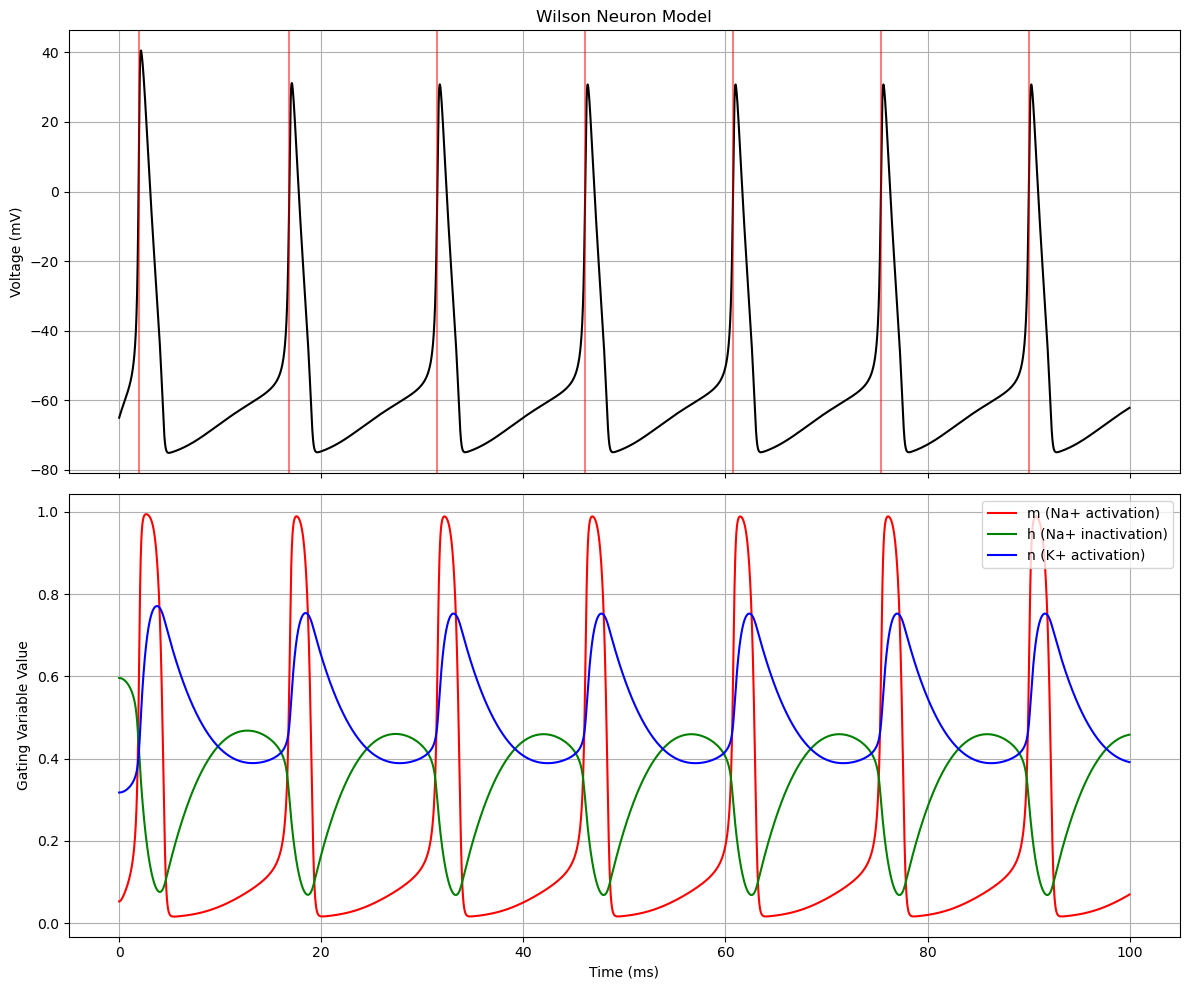

In [5]:
# Set up parameters and run Wilson model
t_max = 100  # ms
dt = 0.01    # ms (smaller dt for numerical stability)
time_steps = np.arange(0, t_max, dt)

wilson_neuron = Wilson(
    Cm=1.0,          # nF
    I=10.0,          # nA (adjust this to see different firing patterns)
    time_steps=time_steps
)

# Run simulation
V, m, h, n, spikes = wilson_neuron.simulate()

# Plot results
wilson_neuron.plot_results(V, m, h, n, spikes)